# Convert the NSIDC sea ice product to a lat-lon grid

The NSIDC V4 G02202 sea ice product was recommended by Walt Meier at NSIDC. It is the most current version, has a netcdf format, and has a consistent definition of sea ice concentration for the time period of interest (2000-2020).

The nominal resolution is 25x25km, but Dr. Meier noted that this is not an equal-area gridding.

This resource is potentially useful, might require creating a new python environment with GDAL:
https://nsidc.org/support/faq/how-can-i-reproject-geotiff-file-polar-stereographic-projecton-geographic-latlon

In [1]:
# gdal already in my cheycomp environment, yay!
from osgeo import gdal

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.

from imports import glob,xr,os,plt,np,xe

In [ ]:
# Example code (for a geoTIFF file format)

# inputfile = "Greenland_vel_mosaic250_vy_v1.tif"
# outputfile = "output.tif"
# #Do not change the following line, it will reproject the geotiff file
# ds = gdal.Warp(outputfile, inputfile, dstSRS="+proj=longlat +datum=WGS84 +no_defs")

The +datum=WGS84 argument here appears to refer to the World Geodetic System standard. There may be a newer version: http://wiki.gis.com/wiki/index.php/WGS84

According to the data product documentation, the coordinate system is: "Unspecified datum based upon the Hughes 1980 ellipsoid" (https://epsg.io/7058-ellipsoid)

Northern Hemisphere: EPSG 3411

I can try using different arguments for +datum, but I doubt the influence will be large.

The in-python documentation doesn't appear to be very helpful.

In [5]:
help(gdal.Warp)

Help on function Warp in module osgeo.gdal:

Warp(destNameOrDestDS, srcDSOrSrcDSTab, **kwargs)
    Warp one or several datasets.
    Arguments are :
      destNameOrDestDS --- Output dataset name or object
      srcDSOrSrcDSTab --- an array of Dataset objects or filenames, or a Dataset object or a filename
    Keyword arguments are :
      options --- return of gdal.WarpOptions(), string or array of strings
      other keywords arguments of gdal.WarpOptions()
    If options is provided as a gdal.WarpOptions() object, other keywords are ignored.



In [37]:
gdal.WarpOptions()

(<osgeo.gdal.GDALWarpAppOptions; proxy of <Swig Object of type 'GDALWarpAppOptions *' at 0x2b93be308ed0> >,
 None,
 None)

### Load example G02202 file

In [4]:
g02202_path = '/glade/work/jonahshaw/obs/NSIDC/G02202_V4/'

In [72]:
g02202_files = glob.glob('%s*monthly*.nc' % (g02202_path))
g02202_files.sort()

In [74]:
g02202_ancilliary_file = 'G02202-cdr-ancillary-nh.nc'
g02202_ancilliary = xr.open_dataset('%s/%s' % (g02202_path,g02202_ancilliary_file))
g02202_test = xr.open_dataset(g02202_files[0])

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'cdr_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'melt_onset_day_cdr_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'nsidc_bt_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'nsidc_nt_seaice_conc_monthly' has _Unsigne

I don't entirely understand how to use this mask. The great lakes are there, which is kind of weird.

This 'month' variable is totally useless, but I'll assume things start in January.

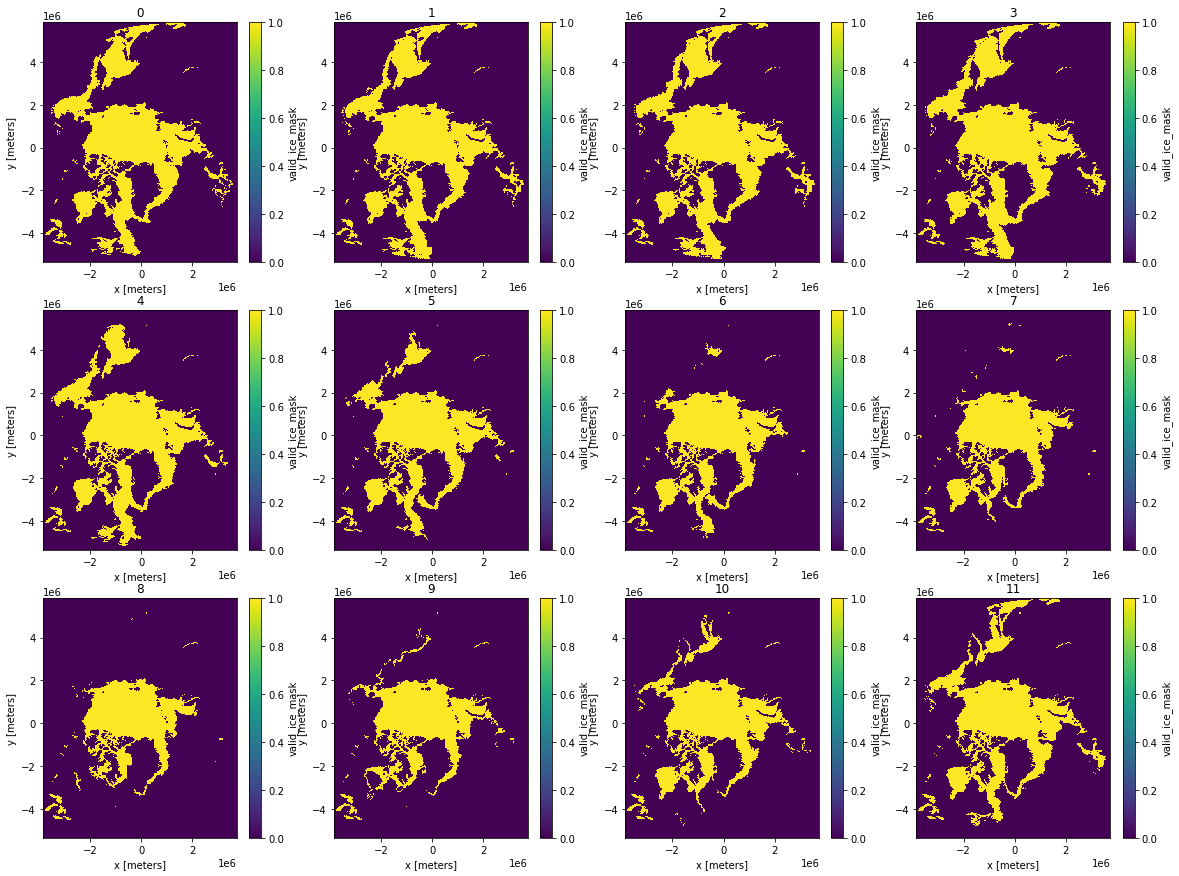

In [81]:
month_fig,month_axs = plt.subplots(3,4,figsize=(20,15))
month_axs = month_axs.flat

for i,(month,_ax) in enumerate(zip(g02202_ancilliary['valid_ice_mask'],month_axs)):
    month.plot(ax=_ax)
    _ax.set_title(i)
    
    

### Latitude and longitude from the ancilliary data looks right.

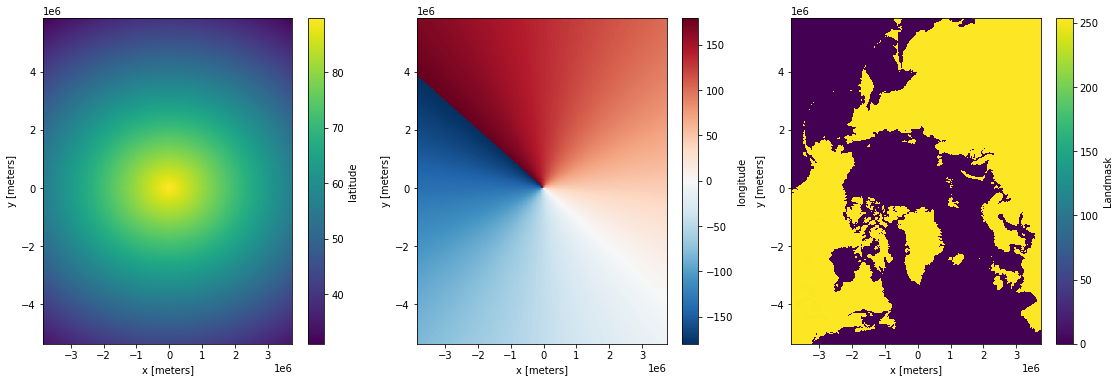

In [18]:
exfig,exaxs = plt.subplots(1,3,figsize=(19,6))

g02202_ancilliary['latitude'].plot(ax=exaxs[0])
g02202_ancilliary['longitude'].plot(ax=exaxs[1])
g02202_ancilliary['landmask'].plot(ax=exaxs[2])

In [41]:
# Define a rectilinear target grid with 0.25 degree resolution
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-89.875, 90., 0.25)),
                     'lon': (['lon'], np.arange(0.125, 360., 0.25)),
                    }
                   )

In [45]:
dr_ctrl = g02202_ancilliary['landmask']

In [49]:
# This doesn't require adding 'lat' or 'lon' as dims
regridder = xe.Regridder(g02202_ancilliary, ds_out, 'bilinear')

In [51]:
dr_out_ctrl = regridder(dr_ctrl)

In [66]:
g02202_test_cleaned = g02202_test.drop_vars('projection')

In [69]:
nsidc_test = regridder(g02202_test_cleaned)

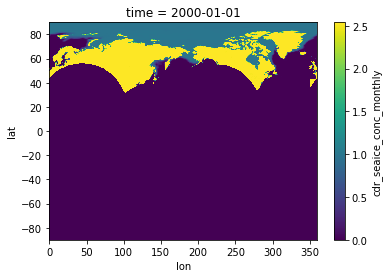

In [71]:
nsidc_test['cdr_seaice_conc_monthly'].plot()

## Interpolate G02202 files

### Set-up

In [2]:
g02202_path = '/glade/work/jonahshaw/obs/NSIDC/G02202_V4/'

In [3]:
g02202_files = glob.glob('%s*monthly*.nc' % (g02202_path))
g02202_files.sort()

In [4]:
g02202_ancilliary_file = 'G02202-cdr-ancillary-nh.nc'
g02202_ancilliary = xr.open_dataset('%s/%s' % (g02202_path,g02202_ancilliary_file))

### Set-up regridder and handle ancilliary data

In [97]:
# Create target resolution grid. Define a rectilinear target grid with 0.25 degree resolution
# Most of the sign inflation comes from xesmf casting variables to float64 type and increasing the grid size.
ds_out = xr.Dataset({'lat': (['lat'], np.arange(49.875, 90., 0.25)),
                     'lon': (['lon'], np.arange(0.125, 360., 0.25)),
                    }
                   )

g02202_ancilliary['notocean'] = xr.where(g02202_ancilliary['landmask']!=0,1,0)

# Create xesmf regridder object for going between the EASE grid and the target 0.25x0.25 grid
regridder = xe.Regridder(g02202_ancilliary, ds_out, 'bilinear') # This step is slow, so we just do it once

# Regrid the ancilliary data (after droping fields w/o lat-lon coordinates
g02202_ancilliary_regridded = regridder(g02202_ancilliary.drop_vars('crs'),keep_attrs=True)

# Correct month coordinate values
g02202_ancilliary_regridded = g02202_ancilliary_regridded.assign_coords(month=np.arange(1,13,1))

# Variables are cast to memory intensive float64 via xesmf. Correct this before saving to give >6x compression
dtype_dict = {'landmask':'uint8',
              'notocean':'float32', # this is an issue. The values for masks, etc are not preserved well here.
              'polehole':'uint8',
#               'valid_ice_mask':'uint8', # messed up by regridding
              'min_concentration':'int16',
              'latitude':'float32',
              'longitude':'float32',
              'month':'uint8',}

for _var in dtype_dict:
    g02202_ancilliary_regridded[_var] = g02202_ancilliary_regridded[_var].astype(dtype_dict[_var])

In [6]:
save_dir = '%s/latlon_gridding/' % g02202_path

In [102]:
# Save interpolated ancilliary data
g02202_ancilliary_regridded.to_netcdf('%s/%s' % (save_dir,g02202_ancilliary_file))

### Regrid individual month NSIDC files

#### Create a function for regridding + datatype managing + time variable adding

In [126]:
# Create a function to interpolate the monthly NSIDC G02202 files
def regrid_g02202(g02202_ds:xr.Dataset,regridder:xr.DataArray,mask:xr.DataArray=None):
    '''
    Interpolate the NSIDC G02202 data product to a 0.25x0.25deg grid using xESMF.
    Preserve data types to minimize memory inflation.
    Mask out land so interpolation doesn't combine the land flag value.
    '''
    
    if (mask != None).any():
        g02202_ds = g02202_ds.where(~mask) # mask out land, applied over all variables
    
    # Drop 'projection' variable, doesn't work with xESMF
    g02202_regridded = regridder(g02202_ds.drop_vars('projection'))
    
    # Iterate over vars and return them to the original datatype (no benefit of going to float64 here)
    for _var in g02202_regridded.var():
        g02202_regridded[_var] = g02202_regridded[_var].astype('float32') # all were originally float32
    g02202_regridded = g02202_regridded.assign_coords(lat = g02202_regridded['lat'].astype('float32'))
    g02202_regridded = g02202_regridded.assign_coords(lon = g02202_regridded['lon'].astype('float32'))
    
    time = g02202_regridded.time.values # hold this
    
    g02202_regridded = g02202_regridded.squeeze().drop_vars('time') # remove the time dimension for whatever reason
    g02202_regridded = g02202_regridded.expand_dims(time=time) # re-add the time dimension
        
    return g02202_regridded    

In [132]:
mask = g02202_ancilliary['landmask'] != 0 # 0: Ocean, 2: Lake, 253: Coast, 254: Land
#^ masks out the coast, is this good?

for i,_path in enumerate(g02202_files):
    _file = _path.split('/')[-1]
    save_path = '%s/%s' % (save_dir,_file)
    
    _ds = xr.open_dataset(_path)
    _ds_regrid = regrid_g02202(_ds,regridder,mask)  
    _ds_regrid.to_netcdf(save_path)
    
#     break
#     if i==2:
#         break

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'cdr_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'melt_onset_day_cdr_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'nsidc_bt_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'nsidc_nt_seaice_conc_monthly' has _Unsigne

### Check that files can be loaded using open_mfdataset

In [217]:
out_files = glob.glob('%s/*monthly*.nc' % save_dir)
out_files.sort()

In [219]:
all_regridded = xr.open_mfdataset(out_files)

## Old stuff related to using gdal and gdal.Warp()

This command runs, but doesn't return anything and doesn't create the new file.

In [ ]:
ds = gdal.Warp(output_path,input_path, dstSRS="+proj=longlat +datum=WGS84 +no_defs")

Try with a file that has been sub-selected to contain a single variable:

In [ ]:
input_path2 = '/glade/work/jonahshaw/obs/NSIDC/G02202_V4/latlon_gridding/seaice_conc_monthly_nh_200001_f13_v04r00.nc'
output_path2 = '/glade/work/jonahshaw/obs/NSIDC/G02202_V4/latlon_gridding/singlevar_pythonwarp.nc'

In [ ]:
ds2 = gdal.Warp(output_path2,input_path2,dstSRS="+proj=longlat +datum=WGS84 +no_defs") # doesn't work with srcSRS="EPSG:3411" either

In [ ]:
ds2

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x2b93d6e4cc00> >

This actually returns something!

In [70]:
python_warp_file = xr.open_dataset('/glade/work/jonahshaw/obs/NSIDC/G02202_V4/latlon_gridding/singlevar_pythonwarp.nc')

In [71]:
python_warp_file

<xarray.Dataset>
Dimensions:  (lat: 77, lon: 1080)
Coordinates:
  * lat      (lat) float64 9.969e+36 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
  * lon      (lon) float64 9.969e+36 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
Data variables:
    Band1    (lat, lon) float32 ...
    crs      |S1 ...
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 3.0.4, released 2020/01/28
    history:      Fri Oct 22 14:08:42 2021: GDAL Create( /glade/work/jonahsha...

This is messed up!

### Load Warped data

In [47]:
test_dir = '/glade/work/jonahshaw/obs/NSIDC/G02202_V4//latlon_gridding/'

In [52]:
testfiles = glob.glob('%s/*.nc' % test_dir)

In [53]:
testfiles

['/glade/work/jonahshaw/obs/NSIDC/G02202_V4//latlon_gridding/testout.nc',
 '/glade/work/jonahshaw/obs/NSIDC/G02202_V4//latlon_gridding/testout3.nc',
 '/glade/work/jonahshaw/obs/NSIDC/G02202_V4//latlon_gridding/testout2.nc',
 '/glade/work/jonahshaw/obs/NSIDC/G02202_V4//latlon_gridding/seaice_conc_monthly_nh_200001_f13_v04r00.nc']

In [54]:
test_ds = xr.open_dataset(testfiles[0])
test_ds2 = xr.open_dataset(testfiles[1])
test_ds3 = xr.open_dataset(testfiles[2])

In [55]:
test_ds3

<xarray.Dataset>
Dimensions:  (lat: 77, lon: 1080)
Coordinates:
  * lat      (lat) float64 31.07 31.4 31.73 32.06 ... 55.12 55.45 55.78 56.11
  * lon      (lon) float64 -178.0 -177.7 -177.3 -177.0 ... 176.8 177.1 177.5
Data variables:
    Band1    (lat, lon) float32 ...
    crs      |S1 ...
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 3.2.0, released 2020/10/26
    history:      Fri Oct 22 13:53:54 2021: GDAL Create( testout2.nc, ... )

This does not look right. Maybe my arguments were wrong with respect to lat,lon?

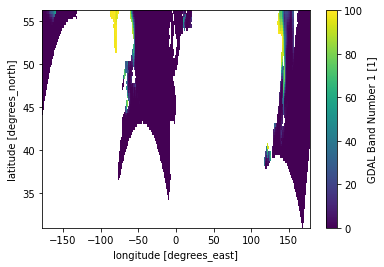

In [46]:
test_ds['Band1'].plot()

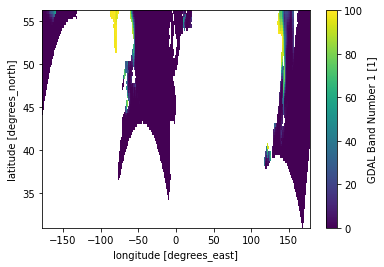

In [51]:
test_ds2['Band1'].plot()